In [1]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Comic Sans MS"

In [63]:
binBoundaries = np.linspace(-0.01,0.01,10000)
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])

In [127]:
## How do you get the true distribution to match the Gaussian norm

true_params = [100, 0.00, 0.002, 100, 0.001, 0.005]
true_dist = true_params[0]/np.sqrt(2*np.pi*true_params[2]**2)*np.exp(-(binCent - true_params[1])**2 / (2 * true_params[2]**2))
#true_dist = np.sqrt(2*np.pi*true_params[2]**2)*np.exp(-(binCent - true_params[1])**2 / (2 * true_params[2]**2))

norm_a = np.random.normal(loc=true_params[1], scale=true_params[2], size=int(1e5))

## Convert this to a line
val, bin_edges= np.histogram(norm_a, bins=binBoundaries, density=True)
val *= true_params[0]

In [128]:
np.sum(val)*(binBoundaries[1]-binBoundaries[0])

99.99999999999706

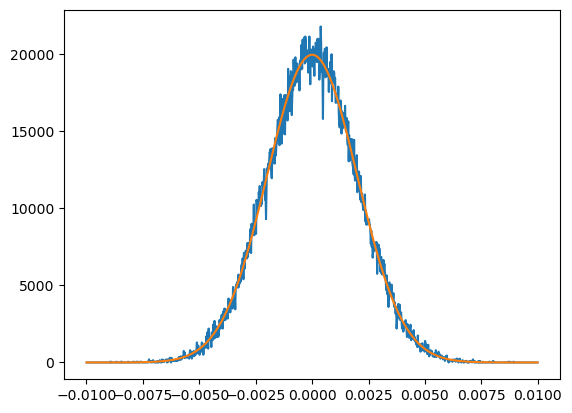

In [129]:
plt.plot(binCent, val)
plt.plot(binCent, true_dist)
plt.show()

## Testing if Gaussian models works as intended

In [186]:
def lnprior(p):
    return 0

'''
Gaussian likelihood with heterodescitic errors ##!!To change to Poisson likelihood

Input:
p: parameters of dimensions (N) or (N,M) with M the array of posterior samples
model: functional model for the fit (see functions below)
x: x data vector
y: y data vector
err: error on the y data vector

Returns:
lp: log probability
'''
def lnlike(p, model, x, y, err):
    # the likelihood is sum of the lot of normal distributions
    x = x[:,np.newaxis]
    y = y[:,np.newaxis]
    err = err[:,np.newaxis]
    
    fit = model(p,x)
    if np.any(np.isnan(fit)):
        return -np.inf

    denom = np.power(err,2)
    lp = -0.5*np.sum(np.power((y - fit),2)/denom + np.log(denom) + np.log(2*np.pi), axis=0)
    lp = np.nan_to_num(lp, nan=-np.inf)
    return lp

'''
Gaussian model
'''
def model(p,x):
    A_1 = p[0]; mu_1 = p[1]; sigma_1 = p[2]; #A_2 = p[3]; mu_2 = p[4]; sigma_2 = p[5]
    #x = x[:,np.newaxis]
    model = A_1/np.sqrt(2*np.pi*sigma_1**2)*np.exp(-(x - mu_1) ** 2 / (2 * sigma_1 ** 2)) #+ A_2* np.exp(-(x - mu_2) ** 2 / (2 * sigma_2 ** 2))
    return model

def lnprob(p, model, x, y, err):
    lp = lnprior(p)

    return lp + lnlike(p, model, x, y, err)
   

In [196]:
Nwalkers = 20
Nsample = int(1e4)
Ndim = 3 ## For Gaussian model

In [197]:
starting_params = [101, 0.001, 0.001]
p0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(Ndim)) for j in range(Nwalkers)])

In [198]:
starting_model = model(starting_params, binCent)

In [199]:
x = binCent[:,np.newaxis]
y = val[:,np.newaxis]
err = y_err[:,np.newaxis]
    
fit = model(starting_params, x)


denom = np.power(err,2)
lp = -0.5*np.sum(np.power((y - fit),2)/denom + np.log(denom) + np.log(2*np.pi), axis=0)

if np.any(np.isnan(fit)):
    lp = -np.inf

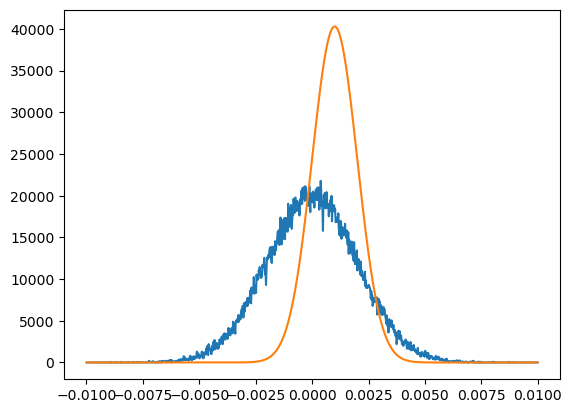

In [200]:
plt.plot(binCent, val)
plt.plot(binCent, starting_model)
plt.show()

In [201]:
y_err = 10*np.ones_like(val)

In [202]:
# Initialize the sampler        
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, lnprob,
                    args=(model, binCent, val, y_err)) ##No backend
        
sampler.run_mcmc(p0, Nsample, progress=True) 

100%|██████████| 10000/10000 [00:26<00:00, 373.99it/s]


State([[9.99724554e+01 1.21486424e-06 1.99618696e-03]
 [9.99745080e+01 1.22919592e-06 1.99621908e-03]
 [9.99806396e+01 9.64249420e-07 1.99640113e-03]
 [9.99714659e+01 1.26705121e-06 1.99623607e-03]
 [9.99773082e+01 1.14834200e-06 1.99639630e-03]
 [9.99764270e+01 1.09202825e-06 1.99623131e-03]
 [9.99819033e+01 1.21952893e-06 1.99635764e-03]
 [9.99812285e+01 1.33857552e-06 1.99618752e-03]
 [9.99775646e+01 1.23063835e-06 1.99616647e-03]
 [9.99788582e+01 1.07599120e-06 1.99624123e-03]
 [9.99707533e+01 1.00515353e-06 1.99603096e-03]
 [9.99748720e+01 1.20629310e-06 1.99622137e-03]
 [9.99858293e+01 1.15366562e-06 1.99646771e-03]
 [9.99771300e+01 1.30653508e-06 1.99625037e-03]
 [9.99792436e+01 1.22204356e-06 1.99630476e-03]
 [9.99744891e+01 1.07273993e-06 1.99629805e-03]
 [9.99770977e+01 9.91208002e-07 1.99617514e-03]
 [9.99713194e+01 1.12951173e-06 1.99611356e-03]
 [9.99782679e+01 1.13141573e-06 1.99637081e-03]
 [9.99825233e+01 9.67071845e-07 1.99644885e-03]], log_prob=[-1127178.22350766 -112

In [204]:
chain = sampler.get_chain(flat=False, thin=10, discard=100)

In [205]:
def check_chains(chain, burn=0, maxlag=1000):
    '''
    Ignoring `burn` samples from the front of each chain, compute convergence criteria and
    effective number of samples.
    '''
    nsteps, nwalk, npars = chain.shape
    if burn >= nsteps: return
    tmp_samples = [chain[burn:,i,:] for i in range(nwalk)]
    print('R =', cr.GelmanRubinR(tmp_samples))
    #print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
    #print('NB: Since walkers are not independent, these will be optimistic!')
    return

In [206]:
check_chains(chain)

R = [1.00006653 0.99997217 1.00016206]


In [207]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.640


In [208]:
print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean autocorrelation time: 44.294 steps


In [209]:
flatchain = chain.reshape((-1,Ndim)).T

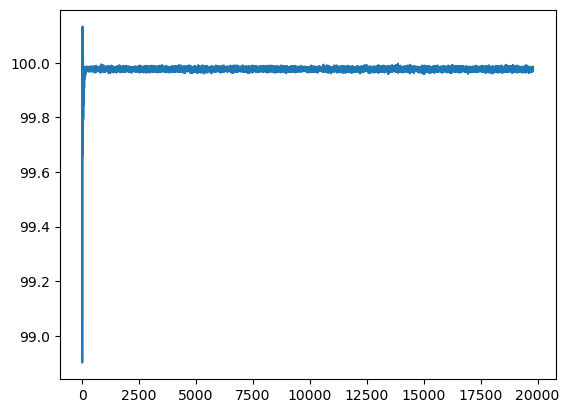

In [211]:
plt.plot(flatchain[0])
plt.show()

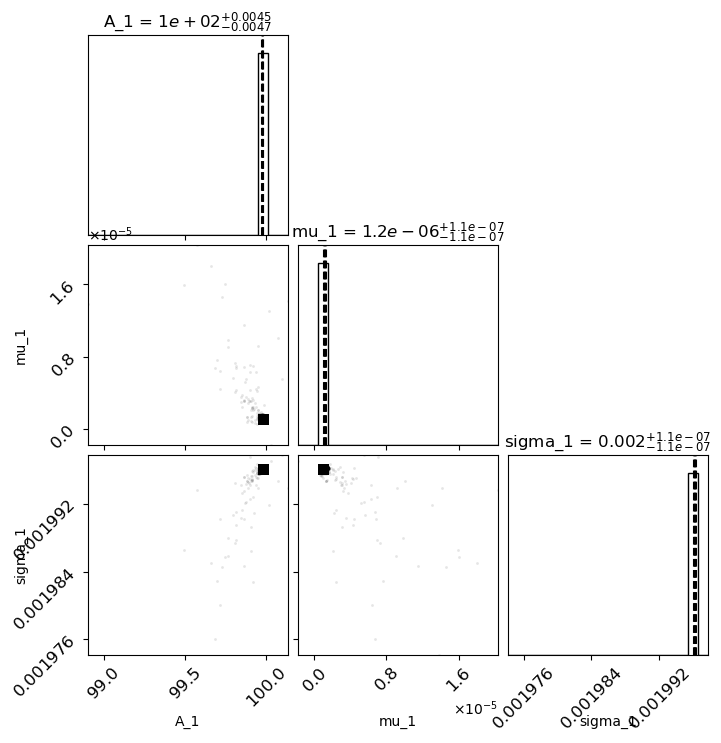

In [212]:
import corner
tmp = corner.corner(flatchain.T, labels=['A_1', 'mu_1', 'sigma_1'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')

In [213]:
## Finding the best fit parameters and estimator

a1, mu1, sigma1 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), \
                                       zip(*np.percentile(flatchain.T, [16, 50, 84], axis=0)))
#print('m_tau: best fit, upper_err, lower_err', m_tau)
#print('m_offset: best fit, upper_err, lower_err', m_offset)
#print('m_height: best fit, upper_err, lower_err', m_height)
#print('m_scale: best fit, upper_err, lower_err', m_scale)

a1 = list(a1)
mu1 = list(mu1)
sigma1 = list(sigma1)


best_fit_params = [a1[0],mu1[0],sigma1[0]]

In [214]:
best_fit_params

[99.97689052458111, 1.1826082979483716e-06, 0.0019962409838555403]